In [1]:
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
    
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: {sys.executable}: command not found
/bin/bash: {sys.executable}: command not found
--2023-05-16 14:51:01--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg’

truck.jpg           100%[===================>] 265.11K  --.-KB/s    in 0.03s   

2023-05-16 14:51:01 (8.53 MB/s) - ‘images/truck.jpg’ saved [271475/271475]

--2023-05-16 14:51:01--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent

In [4]:
sam_checkpoint = "../sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

In [5]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 284 (delta 132), reused 119 (delta 119), pack-reused 80
Receiving objects: 100% (284/284), 18.31 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [6]:
%cd /content/segment-anything

/content/segment-anything


In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [9]:
%%capture
!pip install ftfy regex tqdm matplotlib selectivesearch
!pip install git+https://github.com/openai/CLIP.git


In [10]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

In [12]:

# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(build_sam(checkpoint="/content/sam_vit_h_4b8939.pth"))

In [ ]:
image_path = "assets/example-image.jpg"

In [14]:
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [13]:
def segment_image(image, segmentation_mask,path_save,mask_c):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    black_image.save(f"{path_save}/{mask_c}.jpg")
    return black_image

In [92]:
# Cut out all masks
import glob
import os 
folder_path = "/content/images"
os.makedirs("/content/extract",exist_ok = True)
cropped_boxes = []
masks_list = []

for image_path in glob.glob(f"{folder_path}/*"):
    print("Image Path ",image_path)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(image)
    image = Image.open(image_path)
    subfolder = os.path.basename(image_path).split(".")[0]
    masks_list.append(masks)
    # print("Sub folder path ",subfolder)
    os.makedirs(f"/content/extract/{subfolder}",exist_ok = True)
    for c,mask in enumerate(masks):
        cropped_boxes.append(segment_image(image, mask["segmentation"],f"/content/extract/{subfolder}",c).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

Image Path  /content/images/truck.jpg
Image Path  /content/images/groceries.jpg


In [ ]:
import itertools
print(len(masks_list))
masks = list(itertools.chain.from_iterable(masks_list))
len(masks)

In [98]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [99]:
@torch.no_grad()
def retrieve(elements: list[Image.Image], search_image: list[Image.Image]) -> int:
    preprocessed_images = [preprocess(image).to(device) for image in elements]

    stacked_images = torch.stack(preprocessed_images)
    image_features = model.encode_image(stacked_images)
    preprocessed_images = [preprocess(image).to(device) for image in search_image]

    stacked_images = torch.stack(preprocessed_images)   
    search_features = model.encode_image(stacked_images)
    print(image_features.shape,search_features.shape)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    search_features /= search_features.norm(dim=-1, keepdim=True)
    probs = 100. * image_features @ search_features.T
    return probs[:, 0].softmax(dim=0)

In [100]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

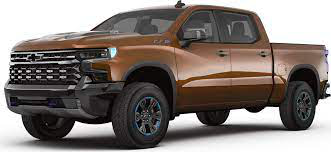

In [119]:
search_path = "/content/truck.jpeg"
search = [Image.open(search_path)]
cv2_imshow(np.array(search[0]))

In [118]:
scores = retrieve(cropped_boxes, search)
print("len of scores ", len(scores))
print(scores)
topk = torch.topk(scores,1).indices
indices = topk.tolist()
print(indices)

torch.Size([214, 512]) torch.Size([1, 512])
tensor([1.1920e-01, 1.3828e-05, 0.0000e+00, 1.1921e-07, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.3842e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.8086e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+

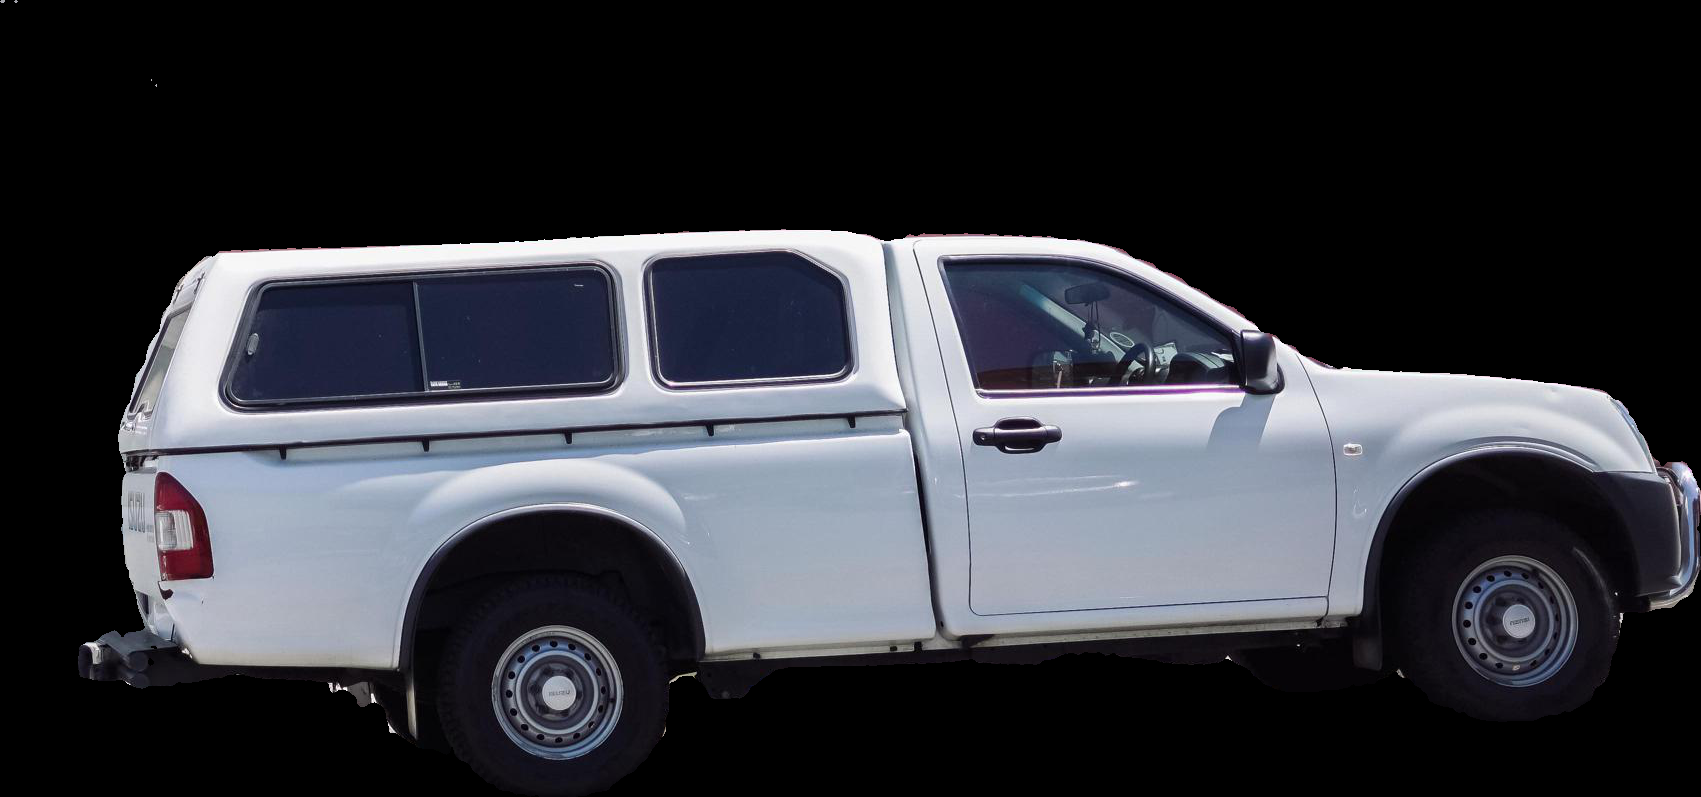

In [115]:
from google.colab.patches import cv2_imshow
cropped_boxes[indices[0]]

In [121]:
masks[indices[0]]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 638688,
 'bbox': [8, 51, 1701, 797],
 'predicted_iou': 0.9690941572189331,
 'point_coords': [[140.625, 581.25]],
 'stability_score': 0.9689740538597107,
 'crop_box': [0, 0, 1800, 1200]}

In [116]:




segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
    segmentation_masks.append(segmentation_mask_image)
image_path = "/content/images/truck.jpg"
original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 200)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image